#### Libraries used

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime, timedelta,date
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix

# CUSTOMER LIFETIME VALUE (CLTV)

Customer Lifetime Value (CLTV) is one of the most important metrics any company can obtain. In a nutshell, it represents the total amount of money a customer is expected to spend in your business, or on your products, during their lifetime. This is an important figure to know because it helps you make decisions about how much money to invest in acquiring new customers and retaining existing ones.

You can read more about CLTV in the following two links:
- [link_1](https://www.shopify.com/encyclopedia/customer-lifetime-value-clv) 
- [link_2](https://towardsdatascience.com/measuring-users-with-customer-lifetime-value-cltv-94fccb4e532e)

The simplest way to calculate CLTV is:

CLTV = average value of a purchase X number of times the customer will buy each year X average length of the customer relationship (in years)

So a marathon runner who regularly buys shoes from your shoe store might be worth:

100 per pair of shoes x 4 pairs per year x 8 years = 100 x 4 x 8= $3,200

And the mom of a toddler might be worth:

20 per pair x 5 pairs per year x 3 years = 20 x 5 x 3 = $300

So who should you be paying more attention to? Clearly, the adult runners in your database.

Over simplifying CLTV equation can be as follows:
- **TOTAL REVENUE** *minus* **TOTAL COSTS**

This has to be applied over a specific period of time tha we define in order to calculate. For example, we can asses the CLTV of a customer over a 6 month period in order to give us some historical data about a customer CLTV.

From there we could train a ML model to predict said customer's CLTV accordingly.

# Identifying features

One, if not the most, important aspect of predicting our CLTV would be identifying the features that we should use to train and predict our model.

In our case, we have already segmented our customer baswed using RFM to shed light on thier associated values and therefore we are going to utilise them as our features.

According to this [article](https://towardsdatascience.com/data-driven-growth-with-python-part-3-customer-lifetime-value-prediction-6017802f2e0f) that helped pave the way for this calculation, we have to split our dataset into two parts:

- One dataframe that houses unique customer_ids and their associated clusters based on a 3 month period
- Another dataframe that houses the revenue of each customer over a 6 month period

One thing to keep in mind is that our data has to be chronological and therefore must be sorted accordingly.

# Dataframe_1

In [2]:
# Import e_commerce dataframe
e_commerce_df1 = pd.read_csv('../datasets/e_commerce_add_customer_types.csv', index_col=0)

In [3]:
e_commerce_df1['invoice_date'] = pd.to_datetime(e_commerce_df1['invoice_date'])

In [4]:
e_commerce_df1.invoice_date.describe()

count                  397884
unique                  17282
top       2011-11-14 15:27:00
freq                      542
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: invoice_date, dtype: object

Our first dataframe could contsin 3 monnth transactional date from the beginning of the year i.e. 2011-01-01 until 2011-03-01

In [5]:
e_commerce_3m_df = e_commerce_df1[(e_commerce_df1.invoice_date < date(2011,4,1)) & (e_commerce_df1.invoice_date >= date(2011,1,1))].reset_index(drop=True)


/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


In [6]:
e_commerce_3m_df.invoice_date.describe()

count                   68331
unique                   3177
top       2011-03-20 13:33:00
freq                      294
first     2011-01-04 10:00:00
last      2011-03-31 19:55:00
Name: invoice_date, dtype: object

## Recency

In [7]:
# We apply RFM segmentaition of e_commerce_3m_df
customers_3m_df = pd.DataFrame(e_commerce_3m_df.groupby('customer_id').max()['invoice_date'].reset_index())

In [8]:
customers_3m_df.rename(columns={'invoice_date':'max_invoice_date'}, inplace = True)

In [9]:
customers_3m_df.dtypes

customer_id                  int64
max_invoice_date    datetime64[ns]
dtype: object

In [10]:
# The recency in days since a customer's last purchase from the company. The higher the less recent.
customers_3m_df['recency'] = customers_3m_df.max_invoice_date.max() - customers_3m_df.max_invoice_date
customers_3m_df.recency = customers_3m_df.recency.dt.days

In [11]:
customers_3m_df

,customer_id,max_invoice_date,recency
0,12346,2011-01-18 10:01:00,72
1,12347,2011-01-26 14:30:00,64
2,12348,2011-01-25 10:42:00,65
3,12350,2011-02-02 16:01:00,57
4,12352,2011-03-22 16:08:00,9
...,...,...,...
1771,18260,2011-03-15 10:34:00,16
1772,18270,2011-03-18 12:41:00,13
1773,18273,2011-03-27 11:22:00,4
1774,18280,2011-03-07 09:52:00,24


In [12]:
#Drop max_invoice_date
customers_3m_df.drop('max_invoice_date', axis=1, inplace = True)

In [13]:
customers_3m_df.describe()

,customer_id,recency
count,1776.000000,1776.000000
mean,15242.054617,31.864302
std,1732.783569,24.485676
min,12346.000000,0.000000
25%,13759.500000,10.000000
50%,15185.500000,28.000000
75%,16745.250000,51.000000
max,18283.000000,86.000000


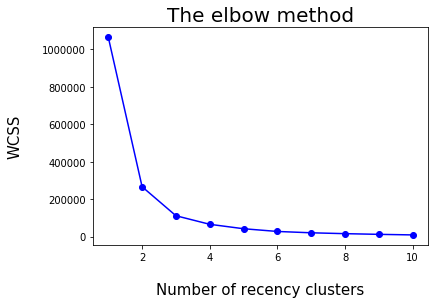

In [14]:
### We use WCSS (within cluster sum of squares) to find the optimum number of clusters for k-means classification 

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(np.array(customers_3m_df.recency).reshape(-1, 1))
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
ax1 = plt.plot(range(1, 11), wcss, 'bo-')
plt.title('The elbow method', fontsize = 20)
plt.xlabel('Number of recency clusters', fontsize = 15, labelpad = 20)
plt.ylabel('WCSS', fontsize = 15, labelpad = 20) #within cluster sum of squares
plt.grid(False)
plt.show()

From the elbow method graph, we can tel that the optimum number of clusters would be 3 (+-1).

In [15]:
kmeans = KMeans(n_clusters=3).fit(np.array(customers_3m_df.recency).reshape(-1, 1))
centroids = kmeans.cluster_centers_
customers_3m_df['recency_cluster'] = kmeans.fit_predict(np.array(customers_3m_df.recency).reshape(-1, 1))
customers_3m_df.head()

,customer_id,recency,recency_cluster
0,12346,72,0
1,12347,64,0
2,12348,65,0
3,12350,57,0
4,12352,9,1


In [16]:
# Check all recency_clusters
customers_3m_df.recency_cluster.value_counts()

1    777
2    551
0    448
Name: recency_cluster, dtype: int64

In [17]:
customers_3m_df.groupby('recency_cluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,448.0,67.071429,9.999297,51.0,58.0,65.0,76.0,86.0
1,777.0,9.402831,6.659900,0.0,3.0,9.0,14.0,22.0
2,551.0,34.912886,7.703579,23.0,29.0,34.0,42.0,50.0


We can see that clusters '0' contains the least inactive customers while cluster '1' has the highest activity and cluster '2' is in the middle.


## Frequency

Following the same principle as recency, we need to identify the total number of orders each cutomer has made in our given timeframe.

In [18]:
customers_freq = pd.DataFrame(e_commerce_3m_df.groupby('customer_id').count()['invoice_no'].reset_index())

In [19]:
customers_freq.rename(columns={'invoice_no':'frequency'}, inplace = True)

In [20]:
customers_freq

,customer_id,frequency
0,12346,1
1,12347,29
2,12348,6
3,12350,17
4,12352,38
...,...,...
1771,18260,61
1772,18270,5
1773,18273,1
1774,18280,10


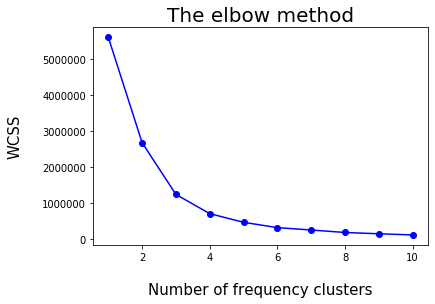

In [21]:
### We use WCSS (within cluster sum of squares) to find the optimum number of clusters for k-means classification 

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(np.array(customers_freq.frequency).reshape(-1, 1))
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
ax1 = plt.plot(range(1, 11), wcss, 'bo-')
plt.title('The elbow method', fontsize = 20)
plt.xlabel('Number of frequency clusters', fontsize = 15, labelpad = 20)
plt.ylabel('WCSS', fontsize = 15, labelpad = 20) #within cluster sum of squares
plt.grid(False)
plt.show()

In [22]:
kmeans = KMeans(n_clusters=3).fit(np.array(customers_freq.frequency).reshape(-1, 1))
centroids = kmeans.cluster_centers_
customers_freq['frequency_cluster'] = kmeans.fit_predict(np.array(customers_freq.frequency).reshape(-1, 1))
customers_freq.head()

,customer_id,frequency,frequency_cluster
0,12346,1,0
1,12347,29,0
2,12348,6,0
3,12350,17,0
4,12352,38,0


Merge customers_freq on customers_3m_df

In [23]:
customers_3m_df = pd.merge(customers_3m_df, customers_freq, on = 'customer_id')

In [24]:
customers_3m_df.tail()

,customer_id,recency,recency_cluster,frequency,frequency_cluster
1771,18260,16,1,61,0
1772,18270,13,1,5,0
1773,18273,4,1,1,0
1774,18280,24,2,10,0
1775,18283,31,2,132,2


In [25]:
customers_3m_df.groupby('frequency_cluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,1549.0,23.773402,17.136657,1.0,10.00,20.0,34.0,70.0
1,13.0,495.923077,166.589046,315.0,356.00,474.0,604.0,778.0
2,214.0,117.098131,45.856530,71.0,84.25,101.0,133.5,296.0


We can see that clusters '0' contains the least frequenct customers while cluster '1' has the highest frequency and cluster '2' is in the middle.


## Monetary

Following the same principle as recency and frequency, we need to identify the total revenue each cutomer has made in our given timeframe.

In [26]:
customers_revenue = pd.DataFrame(e_commerce_3m_df.groupby('customer_id').sum()['revenue'].reset_index())

In [27]:
customers_revenue

,customer_id,revenue
0,12346,77183.60
1,12347,475.39
2,12348,227.44
3,12350,334.40
4,12352,1561.81
...,...,...
1771,18260,1105.82
1772,18270,111.95
1773,18273,51.00
1774,18280,180.60


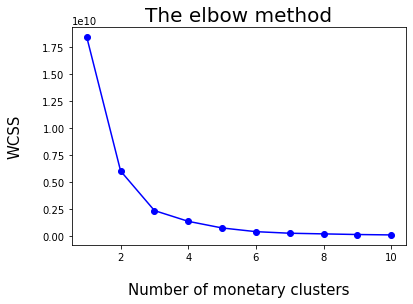

In [28]:
### We use WCSS (within cluster sum of squares) to find the optimum number of clusters for k-means classification 

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(np.array(customers_revenue.revenue).reshape(-1, 1))
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
ax1 = plt.plot(range(1, 11), wcss, 'bo-')
plt.title('The elbow method', fontsize = 20)
plt.xlabel('Number of monetary clusters', fontsize = 15, labelpad = 20)
plt.ylabel('WCSS', fontsize = 15, labelpad = 20) #within cluster sum of squares
plt.grid(False)
plt.show()

In [29]:
kmeans = KMeans(n_clusters=3).fit(np.array(customers_revenue.revenue).reshape(-1, 1))
centroids = kmeans.cluster_centers_
customers_revenue['monetary_cluster'] = kmeans.fit_predict(np.array(customers_revenue.revenue).reshape(-1, 1))
customers_revenue.head()

,customer_id,revenue,monetary_cluster
0,12346,77183.60,2
1,12347,475.39,0
2,12348,227.44,0
3,12350,334.40,0
4,12352,1561.81,0


In [30]:
customers_3m_df = pd.merge(customers_3m_df, customers_revenue, on = 'customer_id')

In [31]:
customers_3m_df

,customer_id,recency,recency_cluster,frequency,frequency_cluster,revenue,monetary_cluster
0,12346,72,0,1,0,77183.60,2
1,12347,64,0,29,0,475.39,0
2,12348,65,0,6,0,227.44,0
3,12350,57,0,17,0,334.40,0
4,12352,9,1,38,0,1561.81,0
...,...,...,...,...,...,...,...
1771,18260,16,1,61,0,1105.82,0
1772,18270,13,1,5,0,111.95,0
1773,18273,4,1,1,0,51.00,0
1774,18280,24,2,10,0,180.60,0


In [32]:
customers_3m_df.groupby('monetary_cluster')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
0,1763.0,687.952206,971.855213,0.85,215.740,387.60,795.220,11517.66
1,11.0,22845.751818,8391.098586,14062.22,16861.680,18884.36,27605.190,37842.74
2,2.0,73960.070000,4558.759845,70736.54,72348.305,73960.07,75571.835,77183.60


We can see that clusters '0' contains the least revenue customers while cluster '2' has the highest frequency and cluster '1' is in the middle.


# Main cluster based on highest value

We need to create one cluster based on the three different cluster types in order to give high/ value to customers.

High value would be a customer that has low recency, high frequency, and high monetary.

For this, our main cluster would be the sum of the cluster number based on the values mentioned above.

We can see that the cluster numbers are not coherent in the sense that cluster order does not follow the logical progression of their corresponding minimums.

We need to manually fix that.

#### Recency cluster

In [33]:
customers_3m_df.groupby('recency_cluster').describe()['recency']

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,448.0,67.071429,9.999297,51.0,58.0,65.0,76.0,86.0
1,777.0,9.402831,6.659900,0.0,3.0,9.0,14.0,22.0
2,551.0,34.912886,7.703579,23.0,29.0,34.0,42.0,50.0


Best cluster would be the one with the least min and so on. Therefore we reclassfiy cluster numbers.

In [34]:
customers_3m_df.replace({'recency_cluster': {0:3, 2:4, 1:5}}, inplace = True)

In [35]:
customers_3m_df.groupby('recency_cluster').describe()['recency']

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
3,448.0,67.071429,9.999297,51.0,58.0,65.0,76.0,86.0
4,551.0,34.912886,7.703579,23.0,29.0,34.0,42.0,50.0
5,777.0,9.402831,6.659900,0.0,3.0,9.0,14.0,22.0


Now cluster 5 is the one with the most recent customers.

We apply the same principle to the rest of the clusters.

In [36]:
customers_3m_df.groupby('frequency_cluster').describe()['frequency']

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,1549.0,23.773402,17.136657,1.0,10.00,20.0,34.0,70.0
1,13.0,495.923077,166.589046,315.0,356.00,474.0,604.0,778.0
2,214.0,117.098131,45.856530,71.0,84.25,101.0,133.5,296.0


In [37]:
# We need the cluster with the highest minimum to be in cluster 5
customers_3m_df.replace({'frequency_cluster': {0:3, 1:5, 2:4}}, inplace = True)

In [38]:
customers_3m_df.groupby('frequency_cluster').describe()['frequency']

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
3,1549.0,23.773402,17.136657,1.0,10.00,20.0,34.0,70.0
4,214.0,117.098131,45.856530,71.0,84.25,101.0,133.5,296.0
5,13.0,495.923077,166.589046,315.0,356.00,474.0,604.0,778.0


In [39]:
customers_3m_df.groupby('monetary_cluster').describe()['revenue']

,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
0,1763.0,687.952206,971.855213,0.85,215.740,387.60,795.220,11517.66
1,11.0,22845.751818,8391.098586,14062.22,16861.680,18884.36,27605.190,37842.74
2,2.0,73960.070000,4558.759845,70736.54,72348.305,73960.07,75571.835,77183.60


In [40]:
# We need the cluster with the highest minimum to be in cluster 5
customers_3m_df.replace({'monetary_cluster': {0:3, 1:4, 2:5}}, inplace = True)

In [41]:
customers_3m_df.groupby('monetary_cluster').describe()['revenue']

,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
3,1763.0,687.952206,971.855213,0.85,215.740,387.60,795.220,11517.66
4,11.0,22845.751818,8391.098586,14062.22,16861.680,18884.36,27605.190,37842.74
5,2.0,73960.070000,4558.759845,70736.54,72348.305,73960.07,75571.835,77183.60


In [42]:
customers_3m_df.tail()

,customer_id,recency,recency_cluster,frequency,frequency_cluster,revenue,monetary_cluster
1771,18260,16,5,61,3,1105.82,3
1772,18270,13,5,5,3,111.95,3
1773,18273,4,5,1,3,51.00,3
1774,18280,24,4,10,3,180.60,3
1775,18283,31,4,132,4,317.90,3


## Create main cluster

In [43]:
# Main cluster can be the sum of all clusters
customers_3m_df['main_cluster'] = customers_3m_df.recency_cluster + customers_3m_df.frequency_cluster + customers_3m_df.monetary_cluster


Now we group by main_cluster and identify the average of recency, frequency, and revenue per main customer cluster in order to identify more valuable customers.

In [44]:
 customers_3m_df.groupby('main_cluster')['recency', 'frequency', 'revenue'].mean()

,recency,frequency,revenue
main_cluster,,,
9,67.128266,19.826603,376.351971
10,36.588679,27.858491,572.393226
11,11.611694,32.454273,850.018966
12,7.788732,117.528169,2337.281549
13,4.818182,375.272727,8883.376364
14,8.250000,556.250000,20740.062500
15,1.000000,530.000000,70736.540000


We can see that cluster 15 has the most valuable customers while cluster 9 has the lowest value customers.

In [45]:
# Customer distribution accross clsuters
pd.DataFrame(customers_3m_df.groupby('main_cluster')['customer_id'].nunique())

,customer_id
main_cluster,
9,421
10,530
11,667
12,142
13,11
14,4
15,1


As per the distribution above, we can simplify it by segmenting customers to low, medium, and high value.

In [46]:
customers_3m_df['customer_segment'] = 'low_value'
customers_3m_df.loc[customers_3m_df['main_cluster'] > 10,'customer_segment'] = 'medium_value' 
customers_3m_df.loc[customers_3m_df['main_cluster'] > 12,'customer_segment'] = 'high_value' 

In [47]:
customers_3m_df

,customer_id,recency,recency_cluster,frequency,frequency_cluster,revenue,monetary_cluster,main_cluster,customer_segment
0,12346,72,3,1,3,77183.60,5,11,medium_value
1,12347,64,3,29,3,475.39,3,9,low_value
2,12348,65,3,6,3,227.44,3,9,low_value
3,12350,57,3,17,3,334.40,3,9,low_value
4,12352,9,5,38,3,1561.81,3,11,medium_value
...,...,...,...,...,...,...,...,...,...
1771,18260,16,5,61,3,1105.82,3,11,medium_value
1772,18270,13,5,5,3,111.95,3,11,medium_value
1773,18273,4,5,1,3,51.00,3,11,medium_value
1774,18280,24,4,10,3,180.60,3,10,low_value


Now we have a customer segmentation result that differentiates customers based on their provided value for the 3 month period we defined earlier.

# Dataframe_2

Like we mentioned, dataframe_2 need to house the revenue of each customer over a 6 month period.


In [48]:
e_commerce_6m_df = e_commerce_df1[(e_commerce_df1.invoice_date >= date(2011,4,1)) & (e_commerce_df1.invoice_date < date(2011,10,1))].reset_index(drop=True)


/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


In [49]:
e_commerce_6m_df.invoice_date.describe()

count                  172007
unique                   7907
top       2011-09-21 14:40:00
freq                      421
first     2011-04-01 08:22:00
last      2011-09-30 15:52:00
Name: invoice_date, dtype: object

In [50]:
e_commerce_6m_df.head()

,customer_id,invoice_no,invoice_date,invoice_year_month,invoice_year,invoice_month,invoice_hour,invoice_day,stock_code,description,quantity,unit_price,revenue,country,min_invoice_date,min_invoice_year_month,user_type
0,13047,551846,2011-05-04 14:11:00,2011-05,2011,5,14,Wednesday,23152,IVORY SWEETHEART WIRE LETTER RACK,4,3.75,15.00,United Kingdom,2010-12-01 08:34:00,2010-12,Existing
1,13047,551846,2011-05-04 14:11:00,2011-05,2011,5,14,Wednesday,23182,TOILET SIGN OCCUPIED OR VACANT,24,0.83,19.92,United Kingdom,2010-12-01 08:34:00,2010-12,Existing
2,13047,551846,2011-05-04 14:11:00,2011-05,2011,5,14,Wednesday,23161,REGENCY CAKE FORK,12,1.25,15.00,United Kingdom,2010-12-01 08:34:00,2010-12,Existing
3,13047,551846,2011-05-04 14:11:00,2011-05,2011,5,14,Wednesday,23160,REGENCY TEA SPOON,12,1.25,15.00,United Kingdom,2010-12-01 08:34:00,2010-12,Existing
4,13047,551846,2011-05-04 14:11:00,2011-05,2011,5,14,Wednesday,23163,REGENCY SUGAR TONGS,8,2.49,19.92,United Kingdom,2010-12-01 08:34:00,2010-12,Existing


In [51]:
customers_6m_df = pd.DataFrame(e_commerce_6m_df.groupby('customer_id').sum()['revenue'].reset_index())

In [52]:
customers_6m_df.columns = ['customer_id', 'revenue_6m']

In [53]:
customers_6m_df.head()

,customer_id,revenue_6m
0,12347,1603.68
1,12348,677.00
2,12352,632.50
3,12353,89.00
4,12354,1079.40


# Merge dataframe_1 & dataframe_2

Here we want to merge both dataframes to get 6 months revenue over the 3 months grouped customers by cluster.

In [54]:
# We use a left join as not to lose any customers from our 3 momnths dataframe. Default join is inner.
customers_merged = pd.merge(customers_3m_df, customers_6m_df, on = 'customer_id', how = 'left')

In [55]:
customers_merged.head()

,customer_id,recency,recency_cluster,frequency,frequency_cluster,revenue,monetary_cluster,main_cluster,customer_segment,revenue_6m
0,12346,72,3,1,3,77183.60,5,11,medium_value,NaN
1,12347,64,3,29,3,475.39,3,9,low_value,1603.68
2,12348,65,3,6,3,227.44,3,9,low_value,677.00
3,12350,57,3,17,3,334.40,3,9,low_value,NaN
4,12352,9,5,38,3,1561.81,3,11,medium_value,632.50


In [56]:
# Fill NaN values with 0
customers_merged = customers_merged.fillna(0)

In [57]:
customers_merged

,customer_id,recency,recency_cluster,frequency,frequency_cluster,revenue,monetary_cluster,main_cluster,customer_segment,revenue_6m
0,12346,72,3,1,3,77183.60,5,11,medium_value,0.00
1,12347,64,3,29,3,475.39,3,9,low_value,1603.68
2,12348,65,3,6,3,227.44,3,9,low_value,677.00
3,12350,57,3,17,3,334.40,3,9,low_value,0.00
4,12352,9,5,38,3,1561.81,3,11,medium_value,632.50
...,...,...,...,...,...,...,...,...,...,...
1771,18260,16,5,61,3,1105.82,3,11,medium_value,1306.68
1772,18270,13,5,5,3,111.95,3,11,medium_value,0.00
1773,18273,4,5,1,3,51.00,3,11,medium_value,102.00
1774,18280,24,4,10,3,180.60,3,10,low_value,0.00


# CLTV

As mentioned earlier, CLTV involves cost calculations but in our dataset that is missing. Therefore we can use revenue as our LTV indicator.

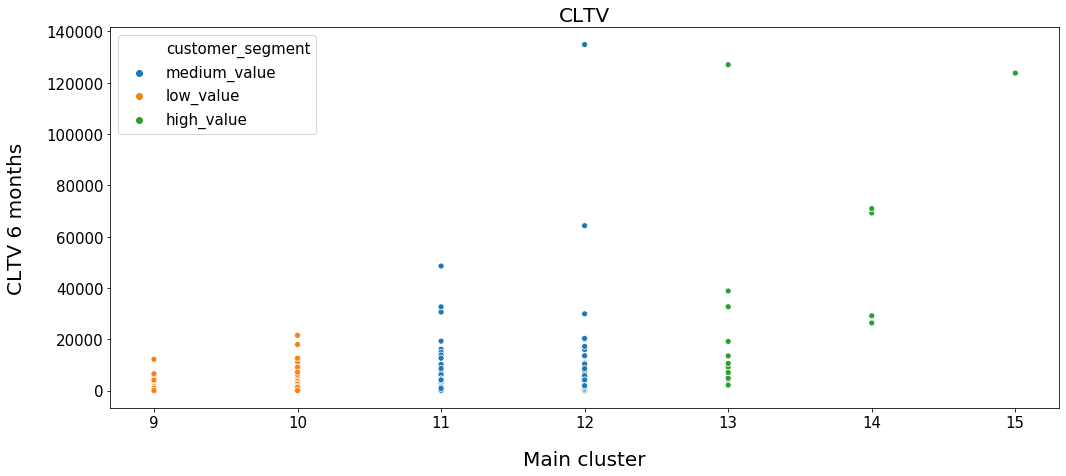

In [58]:
plt.figure(figsize=(17,7))

ax1 = sns.scatterplot(x="main_cluster", y="revenue_6m",hue="customer_segment", data=customers_merged)
ax1.set_xlabel("Main cluster",fontsize=20, labelpad = 20)
ax1.set_ylabel("CLTV 6 months",fontsize=20, labelpad = 20)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('CLTV', fontsize = 20)
plt.grid(False)
plt.legend(fontsize=15)
plt.show()


We can observe some sort of positive correlation between the higher main cluster and the CLTV 6 months.

# K-Means CLTV segments

We understand that CLTV should return a numerical value that represents, in this case, how much revenue a specific customer will contribute to the company. But since this porojects revolves around providing actionable intelligence in order to allocate resources and observe customer behaviour, we will resort to segmenting the CLTV using K-Means.

We use 3 clusters to simplify our approach.

In [59]:
kmeans = KMeans(n_clusters=3).fit(np.array(customers_merged.revenue_6m).reshape(-1, 1))
centroids = kmeans.cluster_centers_
customers_merged['CLTV_cluster'] = kmeans.fit_predict(np.array(customers_merged.revenue_6m).reshape(-1, 1))
customers_merged.head()

,customer_id,recency,recency_cluster,frequency,frequency_cluster,revenue,monetary_cluster,main_cluster,customer_segment,revenue_6m,CLTV_cluster
0,12346,72,3,1,3,77183.60,5,11,medium_value,0.00,0
1,12347,64,3,29,3,475.39,3,9,low_value,1603.68,0
2,12348,65,3,6,3,227.44,3,9,low_value,677.00,0
3,12350,57,3,17,3,334.40,3,9,low_value,0.00,0
4,12352,9,5,38,3,1561.81,3,11,medium_value,632.50,0


In [60]:
customers_merged.groupby('CLTV_cluster')['revenue_6m'].describe()

,count,mean,std,min,25%,50%,75%,max
CLTV_cluster,,,,,,,,
0,1762.0,1131.905398,2132.673604,0.00,0.00,454.655,1305.37,21535.90
1,11.0,42998.090909,17253.808346,26345.79,30242.88,32667.680,56388.12,70918.24
2,3.0,128563.886667,5706.932630,123778.22,125405.83,127033.440,130956.72,134880.00


In [61]:
CLTV_df = customers_merged.copy()

In [62]:
CLTV_df.head()

,customer_id,recency,recency_cluster,frequency,frequency_cluster,revenue,monetary_cluster,main_cluster,customer_segment,revenue_6m,CLTV_cluster
0,12346,72,3,1,3,77183.60,5,11,medium_value,0.00,0
1,12347,64,3,29,3,475.39,3,9,low_value,1603.68,0
2,12348,65,3,6,3,227.44,3,9,low_value,677.00,0
3,12350,57,3,17,3,334.40,3,9,low_value,0.00,0
4,12352,9,5,38,3,1561.81,3,11,medium_value,632.50,0


In [63]:
CLTV_df.CLTV_cluster.value_counts()

0    1762
1      11
2       3
Name: CLTV_cluster, dtype: int64

In [64]:
CLTV_df.groupby('CLTV_cluster')['revenue_6m'].describe()


,count,mean,std,min,25%,50%,75%,max
CLTV_cluster,,,,,,,,
0,1762.0,1131.905398,2132.673604,0.00,0.00,454.655,1305.37,21535.90
1,11.0,42998.090909,17253.808346,26345.79,30242.88,32667.680,56388.12,70918.24
2,3.0,128563.886667,5706.932630,123778.22,125405.83,127033.440,130956.72,134880.00


We can see that CLTV cluster '0' has the lowest mean LTV and therefore would be our lowest priority while cluster '2' has the highest.

# Feature Engineering

By reveiwing the following [article](https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114) we can understand the great emphasis on correct feature engineering.

**One-hot encoding** will be our method of choice since our features are categorical.

According to the aforementioned article:

"*This method changes your categorical data, which is challenging to understand for algorithms, to a numerical format and enables you to group your categorical data without losing any information.*"

In [65]:
# Check which columns are categorical
CLTV_df.head()

,customer_id,recency,recency_cluster,frequency,frequency_cluster,revenue,monetary_cluster,main_cluster,customer_segment,revenue_6m,CLTV_cluster
0,12346,72,3,1,3,77183.60,5,11,medium_value,0.00,0
1,12347,64,3,29,3,475.39,3,9,low_value,1603.68,0
2,12348,65,3,6,3,227.44,3,9,low_value,677.00,0
3,12350,57,3,17,3,334.40,3,9,low_value,0.00,0
4,12352,9,5,38,3,1561.81,3,11,medium_value,632.50,0


In [66]:
# Apply one hot encoding on the customer_segment column
CLTV_dummies = pd.get_dummies(CLTV_df)

In [67]:
CLTV_dummies.head()

,customer_id,recency,recency_cluster,frequency,frequency_cluster,revenue,monetary_cluster,main_cluster,revenue_6m,CLTV_cluster,customer_segment_high_value,customer_segment_low_value,customer_segment_medium_value
0,12346,72,3,1,3,77183.60,5,11,0.00,0,0,0,1
1,12347,64,3,29,3,475.39,3,9,1603.68,0,0,1,0
2,12348,65,3,6,3,227.44,3,9,677.00,0,0,1,0
3,12350,57,3,17,3,334.40,3,9,0.00,0,0,1,0
4,12352,9,5,38,3,1561.81,3,11,632.50,0,0,0,1


# Feature Correlation

 We should try and understand which features correlate more with our CLTV_cluster.

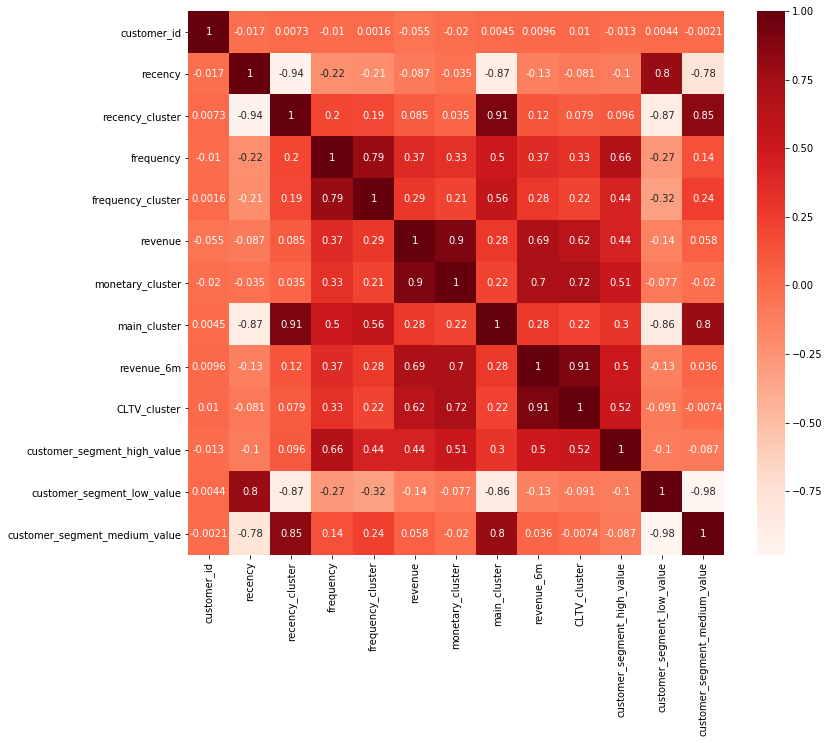

In [68]:
plt.figure(figsize=(12,10))
cor = CLTV_dummies.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig("../images/charts/feature_correlation.png", bbox_inches='tight', dpi=300)
plt.show()

# Features, Target and ML Model

### Features and Traget

In [69]:
# Based on our correlation heatmap, we can deduce the features
features = CLTV_dummies.drop(['CLTV_cluster', 'revenue_6m'], axis = 1)
target = CLTV_dummies['CLTV_cluster']

In [70]:
# Split train_test data by 80-20
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=46)

## Analyzing Model Performance
Next, we are going to build a **Random Forest Regressor**, and test its performance with several different parameter settings.

In [71]:
# Function that calculates this performance metric, and then returns the score.
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # Your code here:
    return r2_score(y_true, y_predict)

In [72]:
# Try different max depths for our 
max_depth_list = [2,4,6,8,10]

In [73]:
r2_test = []
r2_train = []

for depth in max_depth_list:
    regr = RandomForestRegressor(max_depth=depth, random_state=10)
    regr.fit(X_train, y_train)
    y_pred_test = regr.predict(X_test)
    y_pred_train = regr.predict(X_train)
    r2_test.append(performance_metric(y_test, y_pred_test))
    r2_train.append(performance_metric(y_train, y_pred_train))
    


In [74]:
np.mean(r2_test)

0.8330218507533067

In [75]:
np.mean(r2_train)

0.8659874702480123

In [76]:
r2_test = []
r2_train = []

regr = RandomForestRegressor(max_depth=4, random_state=10)
regr.fit(X_train, y_train)
y_pred_test = regr.predict(X_test)
y_pred_train = regr.predict(X_train)
r2_test.append(performance_metric(y_test, y_pred_test))
r2_train.append(performance_metric(y_train, y_pred_train))



## Model results

Referring to our mean r2_test scores we can see that we achieve an accuracy close to 83% which is quite high for what we are trying to achieve. This might seem to be a good model but we need to investigate a little further.

In [77]:
CLTV_dummies.CLTV_cluster.value_counts()

0    1762
1      11
2       3
Name: CLTV_cluster, dtype: int64

Looking at our CLTV cluster, we can see that around 99% of all our customers fall under cluster '0' which maked our current model not a valid one